In [68]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import cuda, int32
from tabulate import tabulate
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32

TPB = 32
iter = 32

In [69]:
@cuda.jit
def gpu_pi(N, rng_states, out):
    thread_id = cuda.grid(1)
    z = 0
    for i in range(N):
        x = xoroshiro128p_uniform_float32(rng_states, thread_id)
        y = xoroshiro128p_uniform_float32(rng_states, thread_id)
        if x*x + y*y < 1:
            z += 1
    out[thread_id] = z * 4 / N

In [70]:
def cpu_pi(N, iter):
    out = np.zeros(iter)
    for i in range(iter):
        x = np.random.uniform(size=N)
        y = np.random.uniform(size=N)
        z = x*x + y*y < 1
        out[i] = 4 * sum(z) / N
    return out

C:\Users\Dmitry\AppData\Local\Programs\Python\Python39\lib\site-packages\numba\cuda\cudadrv\devicearray.py:790: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
C:\Users\Dmitry\AppData\Local\Programs\Python\Python39\lib\site-packages\numba\cuda\compiler.py:865: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (12) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


|   Число точек |   Результат на CPU |   Результат на GPU |   Время на CPU, мс |   Время на GPU, мс |
|--------------:|-------------------:|-------------------:|-------------------:|-------------------:|
|        100000 |            3.14297 |            3.14215 |             7.017  |          0.0320005 |
|        150000 |            3.14154 |            3.14224 |            10.532  |          0.0640004 |
|        200000 |            3.1421  |            3.1425  |            14.007  |          0.0609999 |
|        250000 |            3.1425  |            3.1424  |            17.586  |          0.0789938 |
|        300000 |            3.1414  |            3.14235 |            21.069  |          0.085999  |
|        350000 |            3.14208 |            3.14216 |            24.1743 |          0.177999  |
|        400000 |            3.14158 |            3.14213 |            27.8203 |          0.107987  |
|        450000 |            3.1421  |            3.1419  |            31.1643 |  

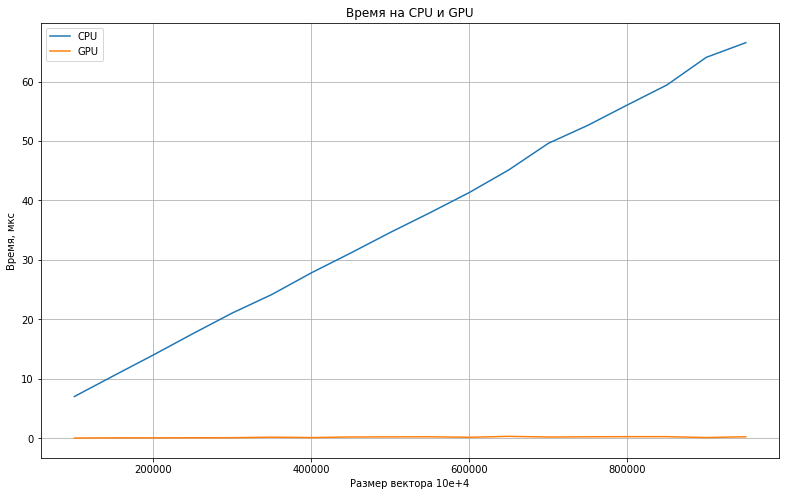

In [71]:
rows = []

for i in range(50000, 1000000, 50000):

    start = time.time()
    cpu_pi_res = cpu_pi(i, iter).mean()
    cpu_t = time.time() - start

    start = time.time()
    rng_states = create_xoroshiro128p_states(TPB, seed=1)
    out = np.zeros(TPB, dtype=np.float32)
    gpu_pi[1, TPB](i, rng_states, out)
    gpu_pi_res = out.mean()
    gpu_t = time.time() - start   

    row = [i, cpu_pi_res, gpu_pi_res, cpu_t, gpu_t]
    rows.append(row)
del rows[0]

print(tabulate(rows, headers=['Число точек', 'Результат на CPU', 'Результат на GPU', 'Время на CPU, мс', 'Время на GPU, мс'], tablefmt='pipe'))

points = list(map(lambda x: x[0], rows))
cpu = list(map(lambda x: x[3], rows))
gpu = list(map(lambda x: x[4], rows))

plt.figure(figsize=(45,8))

plt.subplot(1, 3, 1)
plt.title("Время на CPU и GPU")
plt.plot(points, cpu, points,  gpu)
plt.legend(['CPU','GPU'])
plt.xlabel("Размер вектора 10е+4")
plt.ylabel("Время, мкс")
plt.grid()

plt.show()